In [286]:
# import packages
import cv2
import warnings
from tqdm import tqdm
from sklearn.metrics import roc_curve
import skimage
from skimage.filters import try_all_threshold, threshold_otsu
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy.spatial.distance import cosine, euclidean, cdist
import os
import requests
import sys
import random
import itertools
from typing import Tuple
from PIL import Image, ImageDraw, ImageFont
import glob
from datetime import datetime, timedelta

import warnings
warnings.filterwarnings('ignore')

In [ ]:
BACKGROUNDS_PATH = "./data/backgrounds"
MRZs_PATH = "data/mrzs.txt"
OUTPUT_PATH = "Datasets/ENGLISH/Synthetic_Rec_En_V9"
FONTS_PATH = "data/fonts/en_fonts"
MAX_NUM_WORDS = 6
TEXT_PROBS = dict({
    "text": 0.5,
    "date": 0.2,
    "mrz": 0.3,
    "number": 0.1
    
})
assert round(sum(TEXT_PROBS.values())) == 1.0, "Text probs should add upto 1"

OCR_MODEL_INPUT_SHAPE = (624, 36)

OUTPUT_TRAIN_PATH = os.path.join(OUTPUT_PATH, "train")
OUTPUT_TEST_PATH = os.path.join(OUTPUT_PATH, "test")
os.makedirs(OUTPUT_TRAIN_PATH, exist_ok=True)
os.makedirs(OUTPUT_TEST_PATH, exist_ok=True)

BACKGROUNDS = []
for bg_name in os.listdir(BACKGROUNDS_PATH):
    basename, ext = os.path.splitext(bg_name)
    if ext in ['.jpg', '.png', '.jpeg']:
        BACKGROUNDS.append(os.path.join(BACKGROUNDS_PATH, bg_name))

print("Total backgrounds found:", len(BACKGROUNDS))
# download a list of words for use as background text
word_site = "https://www.mit.edu/~ecprice/wordlist.100000"
response = requests.get(word_site)
WORDS = [x.decode() for x in response.content.splitlines()]

# list of font types to exclude
FONTS_LIST = []
FONTS_WEIGHTS = []
for font_path in glob.glob(os.path.join(FONTS_PATH, "**", "*.ttf"), recursive=True):
    FONTS_LIST.append(font_path)    
    if "Passport" in font_path:
        FONTS_WEIGHTS.append(5)
    elif "Visa" in font_path:
        FONTS_WEIGHTS.append(1)
    else:
        FONTS_WEIGHTS.append(2)

MRZs = []
with open(MRZs_PATH, "r") as reader:
    MRZs = [r.replace("\n", "").strip() for r in reader.readlines()]

MRZs.extend(generate_mrz_list(2000))
PUNCTUATIONS = ['-', '<', '/', ',', "'", ':', '&', '.', '(', ')']

Total backgrounds found: 101


## Helper Functions

#### Generate MRZs

In [293]:
import random
import string

def random_string(length):
    return ''.join(random.choices(string.ascii_uppercase, k=length))

def random_name(length, num_words):
    surname = True
    name = ""
    count = 0
    while len(name) < length and count <= num_words:
        word__ = random_string(random.randint(3, 12))
        if surname:
            word__ += "<<"
            surname = False
        else:
            word__ += "<"
        name += word__
        if len(name) > length:
            name = name[:length]
        count += 1
    if len(name) < length:
        name = name + "<" * (length - len(name))
    return name

def random_digits(length):
    return ''.join(random.choices(string.digits, k=length))

def maybe_pad(content, total_length):
    if random.choice([True, False]):
        return content + '<' * (total_length - len(content))
    else:
        return content + random_string(total_length - len(content))

def generate_mrz_td1():
    line1 = f"I{random.choice(['L', 'D'])}{''.join(random.choices(string.ascii_uppercase, k=3))}{random_digits(9)}"
    line1 = line1 + (random_digits(30 - len(line1)) if random.choice([True, False]) else "")
    line1 = maybe_pad(line1, 30)
    line2 = f"{random_digits(7)}{random.choice(['M', 'F'])}{random_digits(7)}{''.join(random.choices(string.ascii_uppercase, k=3))}"
    line2 = maybe_pad(line2, 30)
    line2 = line2[:-1] + "<" if random.choice([True, False]) else line2[:-1] + random_digits(1)
    line3 = random_name(30, random.randint(1, 3))
    return [line1, line2, line3]
    
def generate_mrz_td3():
    line1 = f"P{random.choice(['M', 'D', 'O', '<', '<', '<'])}{''.join(random.choices(string.ascii_uppercase, k=3))}"
    line1 = line1 + random_name(44 - len(line1), random.randint(2, 4))
    # line1 = maybe_pad(line1, 44)

    line2 = f"{random_digits(10)}{''.join(random.choices(string.ascii_uppercase, k=3))}{random_digits(7)}{random.choice(['M', 'F'])}{random_digits(7)}"
    line2 = line2 + (random_digits(44 - len(line2)) if random.choice([True, False]) else "")
    line2 = maybe_pad(line2, 44)
    
    return [line1, line2]

def generate_mrz_list(n):
    mrz_list = []
    for _ in range(n):
        mrz_list.extend(random.choice([generate_mrz_td1, generate_mrz_td3])())
    return mrz_list


In [294]:
from random import randint
import string
from PIL import ImageOps, ImageChops, ImageFilter
from datetime import datetime, timedelta
import math


def resizeAndPadImage(img):
    input_width, input_height = OCR_MODEL_INPUT_SHAPE[:2]
    h, w, c = img.shape
    ratio = w / h
    resized_w = int(input_height * ratio)
    # Resize the width if it exceeds the input width
    isBottomPad = False
    resized_h = input_height
    if resized_w > input_width:
        resized_w = input_width
        resized_h = int(h / w * input_width)
        isBottomPad = True
    # Resize image while preserving aspect ratio
    img = cv2.resize(img, (resized_w, resized_h), interpolation=cv2.INTER_AREA)
    # Prepare target tensor with appropriate dimensions
    target = np.zeros((input_height, input_width, 3), dtype=np.uint8)
    # Place the resized image into the target tensor
    if isBottomPad:
        target[:resized_h, :, :] = img
    else:
        target[:, :resized_w, :] = img
    return target


def generate_random_date():
    # Generate a random year, month, and day
    year = random.randint(1900, 2100)
    # month = random.randint(1, 12)
    month = random.choices(
        list(range(1, 13)),
        weights=[4 if v in [1, 4, 11] else 1 for v in range(1, 13)],
        k=1
    )[0]
    
    # Generate a random day based on the selected month (and considering leap years)
    max_day = (datetime(year, month % 12 + 1, 1) - timedelta(days=1)).day
    # day = random.randint(1, max_day)
    day = random.choices(
        list(range(1, max_day + 1)),
        weights=[4 if v in [1, 4, 11, 14, 21, 24] else 1 for v in range(1, max_day + 1)],
        k=1
    )[0]
    
    # Create a datetime object with the generated date
    date_obj = datetime(year, month, day)
    # Choose different date formats
    formats = dict({
        "%Y-%m-%d": 0.1,    # YYYY-MM-DD
        "%d-%m-%Y": 0.1,    # DD-MM-YYYY
        "%Y/%m/%d": 0.1,    # YYYY/MM/DD
        "%Y/%m/%d": 0.1,    # YYYY/MM/DD
        "%Y/%m/%d": 0.1,    # YYYY/MM/DD
        "%d/%m/%Y": 0.1,    # DD/MM/YYYY
        "%d/%m/%Y": 0.1,    # DD/MM/YYYY
        "%d/%m/%Y": 0.1,    # DD/MM/YYYY
        "%m/%d/%Y": 0.1,    # MM/DD/YYYY
        "%m/%d/%Y": 0.1,    # MM/DD/YYYY
        "%m/%d/%Y": 0.1,    # MM/DD/YYYY
        "%d.%m.%Y": 0.3,    # DD.MM.YYYY
        "%d %m %Y": 0.3,    # DD MM YYYY
        "%b %d, %Y": 0.5,   # Abbreviated month, day, year (e.g., Jan 13, 2023)
        "%d %b %Y": 0.5,   # Abbreviated month, day, year (e.g., 13 Jan 2023)
        "%d %b/%b %Y": 0.5,   # Abbreviated month, day, year (e.g., 13 Jan/Jan 2023)
        "%B %d, %Y": 0.2,    # Full month name, day, year (e.g., January 13, 2023)
        "%d %B %Y": 0.2,    # Full month name, day, year (e.g., January 13, 2023)
    })
    # Choose a random format
    date_format = random.choices(list(formats.keys()), weights=list(formats.values()), k=1)[0]

    date_ = date_obj.strftime(date_format)
    if date_format == "%d %b/%b %Y":
        elems = date_.split()
        d = elems[0]
        m = elems[1].split("/")[0]
        y = elems[2]
        r = "".join(random.choices(string.ascii_uppercase, k=random.randint(3, 4)))
        m1 = random.choice([m, r])
        m2 = m if m1 == r else r
        date_ = f"{d} {m1}/{m2} {y}"

    if date_format in ["%b %d, %Y", "%d %b %Y", "%d %b/%b %Y"]:
        date_ = date_.upper()
        
    # Return the formatted date string
    return date_

def get_pil_font(font_list, font_size=22, font_weights=None):
    # Randomly select a font from a list of common fonts
    font_path = random.choices(FONTS_LIST, font_weights, k=1)[0]
    font = ImageFont.truetype(font_path, font_size)    
    return font, font_path


def add_background(size):
    index_random = random.randint(0, len(BACKGROUNDS) - 1)
    img = Image.open(BACKGROUNDS[index_random])
    img = img.resize(size)
    draw = ImageDraw.Draw(img)
    return img


def apply_motion_blur(image, kernel_size=15, orientation=0):
    # Create a motion blur kernel
    kernel = np.zeros((kernel_size, kernel_size))
    if orientation == 0:
        kernel[int((kernel_size - 1) / 2), :] = np.ones(kernel_size)
    else:
        kernel[:, int((kernel_size - 1) / 2)] = np.ones(kernel_size)
    kernel = kernel / kernel_size
    # Apply the kernel to the image
    blurred = cv2.filter2D(image, -1, kernel)
    return blurred

def apply_bokeh_blur(image, kernel_size=15, radius=7):
    # Create the bokeh kernel
    """Create a circular bokeh kernel."""
    kernel = np.zeros((kernel_size, kernel_size), dtype=np.float32)
    center = kernel_size // 2
    for i in range(kernel_size):
        for j in range(kernel_size):
            if (i - center)**2 + (j - center)**2 <= radius**2:
                kernel[i, j] = 1
    kernel /= np.sum(kernel)

    # Apply the kernel to the image
    blurred = cv2.filter2D(image, -1, kernel)
    return blurred

def getTwoLined(text):
    words = text.split()
    if len(words) < 2:
        return text
    split_word = words[random.randint(1, len(words)-1)]
    strs = sorted([w.strip() for w in text.split(split_word) if len(w) > 0], key=lambda x: len(x), reverse=True)
    return '\n'.join(strs) if len(strs) > 1 else strs[0]


# Generate Moire Pattern
def add_moire_patterns(image, alpha=0.2):
    """
    Generates a moire pattern using sinusoidal waves.
    Parameters:
    - height: Height of the pattern
    - width: Width of the pattern
    - frequency: Frequency of the sine wave
    - amplitude: Amplitude of the sine wave
    Returns:
    - Moire pattern as a 2D numpy array
    """
    image = cv2.cvtColor(np.array(image, dtype=np.uint8), cv2.COLOR_BGR2RGB)
    height, width = image.shape[:2]
    # Initialize the RGB pattern with zeros
    pattern_rgb = np.zeros((height, width, 3), dtype=np.uint8)
    for channel in range(3):  # Iterate over R, G, B channels
        frequency = random.uniform(10, 30)
        amplitude = random.uniform(5, 15)
        angle = random.uniform(0, np.pi) * random.choice([-1, 1])

        x = np.arange(0, width)
        y = np.arange(0, height)
        X, Y = np.meshgrid(x, y)
        # Create a sinusoidal pattern with some phase shift
        pattern = amplitude * np.sin(2 * np.pi * frequency * X / width + 2 * angle * frequency * Y / height)
        # Normalize the final pattern to the range [0, 255] and assign to the respective RGB channel
        pattern_rgb[:, :, channel] = ((pattern - np.min(pattern)) / (np.max(pattern) - np.min(pattern)) * 255).astype(np.uint8)

    noisy_image = cv2.addWeighted(image, 1 - alpha, pattern_rgb, alpha, 0)
    return Image.fromarray(noisy_image)


def guassianBlur(img, *kwargs):
        return img.filter(ImageFilter.GaussianBlur(random.uniform(0.4, 1)))


def motionBlur(img, *kwargs):
    return Image.fromarray(
        apply_motion_blur(
            np.array(img, dtype=np.uint8), 
            kernel_size=random.randint(3, 6), 
            orientation=random.randint(1, 2)
        ))
    
def bokenBlur(img, *kwargs):
    if kwargs:
        img_w = kwargs[0]
        
    return Image.fromarray(
        apply_bokeh_blur(
            np.array(img, dtype=np.uint8), 
            kernel_size=random.randint(3, 6), 
            radius=int(random.uniform(0.02, 0.6) * img_w)
        ))

### Get Sample Method

In [295]:
from random import randint
import string
from PIL import ImageOps, ImageChops, ImageFilter, ImageEnhance
from datetime import datetime, timedelta
from collections import Counter


def get_sample(
    max_num_words, 
    fonts,
    text_probs,
    text=None, 
    font_path=None, 
    get_text_only=False,
    two_lined_samples=False,
    font_size=52,
    font_weights=None
):
    isText = True
    toCase = str.upper
    if font_path is None:
        font, font_path = get_pil_font(fonts, font_size=font_size, font_weights=font_weights)
    else:
        font = ImageFont.truetype(font_path, font_size)
        
    if text is None:
        toCase = None
        isText = False
        toGenerate = random.choices(list(TEXT_PROBS.keys()), weights=TEXT_PROBS.values(), k=1)[0]
        if toGenerate == "text":
            # generate text
            text = (random.randint(1, 2) * ' ').join(random.sample(
                WORDS, 
                random.choice([*list(range(1, max_num_words)), *[1, 1]])
            ))
            if two_lined_samples:
                text = getTwoLined(text)     # get two lines text, can also return single line
                
            toCase = random.choices(
                population=[str.upper, str.lower, str.capitalize, str.title], weights=[0.8, 0.05, 0.05, 0.1], k=1
            )[0]
            text = toCase(text)
            # add random punctuations
            if random.uniform(0, 1) > 0.7:
                punct = random.choice(PUNCTUATIONS)
                if punct not in ['<']:                
                    si = random.choice([*[i for i, x in enumerate(text) if x == ' '], *[0, len(text) - 1]])
                    ps = random.choice([f' {punct}', f' {punct} ', f'{punct} '])
                    text = text[:si] + ps + text[si + 1:]
                    
            if random.uniform(0, 1) > 0.5 and toCase == str.upper:
                text = text.split()[0] + ", " + " ".join(text.split()[1:])

            # add specified chars to the words randomly
            if random.uniform(0, 1) > 0.7 and toCase == str.upper:
                for _ in range(3):
                    char = random.choice(['I', 'Q', 'O', '0', 'W', 'M', 'N', 'V', 'X', 'B', 'L', 'T', 'AA', '3', '8'])
                    si = random.choice([*[i for i, x in enumerate(text) if x == ' '], *[0, len(text) - 1]])
                    ps = random.choice([f' {char}', f'{char} '])
                    text = text[:si] + ps + text[si + 1:]
            isText = True
            
        elif toGenerate == "mrz":
            # generate MRZs
            text = random.choice(MRZs)
        elif toGenerate == "date":
            text = generate_random_date()
        else:
            # generate number
            l = []
            for _ in range(random.randint(1, 15)):
                if random.random() > 0.3:
                    letter = string.digits[random.randint(0, 9)]
                else:
                    letter = random.choice([string.ascii_uppercase[random.randint(0, 25)], "-"])
                l.append(letter)
            text = ''.join(l)
    
    if get_text_only:
        return ' '.join(text.split()), None
    
    textsize = font.getsize(text.split("\n")[0])
    char_freq = Counter(text)
    letter_spacing = 0
    # add random spacing
    if isText and toCase == str.upper:
        if random.random() > 0.4:
            letter_spacing = random.randint(1, 5)
    
    # get image size
    img_w, img_h = 0, 0
    for char in text.split("\n")[0]:
        char_width, char_height = font.getsize(char)
        img_w += char_width + letter_spacing
        img_h = max(char_height, img_h)
    
    offset_x, offset_y = int(random.uniform(0.01, 0.1)*img_w), int(random.uniform(0.2, 0.5) * img_h)
    size = (img_w + offset_x, img_h * (char_freq['\n'] + 1) + offset_y)
    
    img = add_background(size) if random.uniform(0, 1) > 0.2 else Image.new('L', size, color='white')
    draw = ImageDraw.Draw(img)
    
    # Initial x and y positions
    x, y = random.randint(0, offset_x) , random.randint(0, offset_y//3)
    init_x = x
    # Draw each character with custom horizontal spacing and, slight location change in y
    ofst_y__ = (img_h - char_height) / len(text)
    ofst_y__ = (random.choice([1, -1]) *  ofst_y__)
    color = random.choice(["#2f2f2f", "black", "#404040"])
    for char in text:
        if char == "\n":
            y += char_height
            x = init_x
            continue
        char_width, char_height = draw.textsize(char, font=font)
        draw.text((x, y), char, fill=color, font=font, align="center")
        x += char_width + letter_spacing
        y += ofst_y__

    img = img.convert("RGB")
    
    # apply blur
    if random.random() > 0.3:
        _, font_name = os.path.split(font_path)
        img = img.filter(ImageFilter.GaussianBlur(0.7))
    
    isUpper = toCase == str.upper
    if random.random() > 0.6 and isUpper:
        img = img.filter(ImageFilter.GaussianBlur(random.uniform(0.3, 0.9)))
    
    # apply blur
    if random.random() > 0.6:
        for op in random.choices([guassianBlur, motionBlur, bokenBlur], k=2):
            img = op(img, img_w)
    elif random.random() > 0.4:    # apply motion blur  
        img = motionBlur(img)
    elif random.random() > 0.2:    # boken blur
        img = bokenBlur(img, img_w)
    else:
        img = guassianBlur(img)
        
    img = img.convert("RGB")
    # resize image randomly
    new_size = None
    if random.random() > 0.7:
        resize_factor = random.uniform(0.9, 1)
        w, h = img.size
        new_size = (int(w * resize_factor), int(h * resize_factor))
    
    # stretching both sides
    if random.random() > 0.6:
        w, h = new_size if new_size is not None else img.size
        if random.random() > 0.5:
            new_h = h + int(h * random.uniform(0.1, 0.3))
        else:
            new_h = h - int(h * random.uniform(0.05, 0.2))   
        img = img.resize((w, new_h))
    else:
        if new_size is not None:
            img = img.resize(new_size)
    
    # crop randomly
    if random.random() > 0.5:
        w, h = img.size
        x1 = random.uniform(0.008, 0.01) * w
        y1 = random.uniform(0.01, 0.1) * h
        x2 = w - (random.uniform(0.008, 0.01) * w)
        y2 = h - (random.uniform(0.01, 0.1) * h)
        img = img.crop((x1, y1, x2, y2))
    
    # add some opacity
    if random.random() > 0.5:
        img.putalpha(random.randint(150, 210))

    if random.random() > 0.7:
        img = add_moire_patterns(img, alpha=random.uniform(0.1, 0.3))
    
    # change brighness randomly
    enhancer = ImageEnhance.Brightness(img)
    img = enhancer.enhance(random.uniform(0.7, 1.2))
    
    # remove the extra spaces if any
    text = ' '.join(text.split())
    return text, img.convert("RGB")

### Visualize

Num Fonts: 37


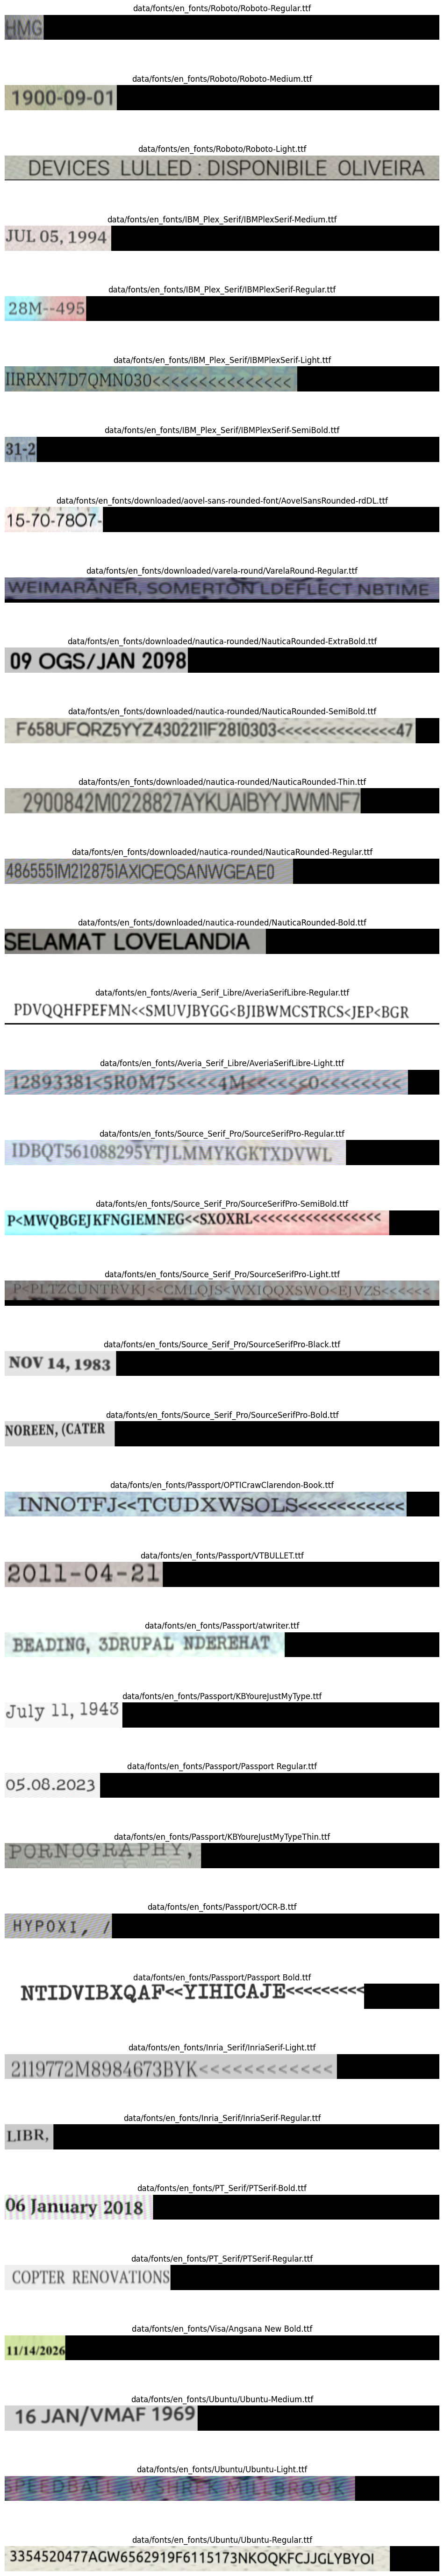

In [297]:
# list of font types to exclude
# list of font types to exclude
FONTS_LIST = []
FONTS_WEIGHTS = []
for font_path in glob.glob(os.path.join(FONTS_PATH, "**", "*.ttf"), recursive=True):
    FONTS_LIST.append(font_path)    
    if "Passport" in font_path:
        FONTS_WEIGHTS.append(5)
    elif "Visa" in font_path:
        FONTS_WEIGHTS.append(1)
    else:
        FONTS_WEIGHTS.append(2)

print("Num Fonts:", len(FONTS_LIST))

plt.figure(figsize=(12, 72))
for i, font_path in enumerate(FONTS_LIST):
    text = "Muhammad Abdullah KHAN"
    text, img = get_sample(
        MAX_NUM_WORDS, FONTS_LIST, TEXT_PROBS, text=None, two_lined_samples=False, font_path=font_path, font_size=48, font_weights=FONTS_WEIGHTS
    )
    ax = plt.subplot(len(FONTS_LIST), 1, i + 1)
    img = Image.fromarray(resizeAndPadImage(np.array(img)))
    plt.imshow(img)
    plt.title(font_path)
    plt.axis("off")
plt.show()

In [298]:
from tqdm import tqdm
from atpbar import atpbar
import os
import multiprocessing
from threading import Thread


NUMBER_IMAGES_TO_GENERATE = 90000
TRAIN_TEST_SPLIT_PERCENTAGE = 0.1
NUMBER_THREADS = 10

os.makedirs(os.path.join(OUTPUT_TEST_PATH, "images"), exist_ok=True)
os.makedirs(os.path.join(OUTPUT_TRAIN_PATH, "images"), exist_ok=True)
    

def generate__(pid, num_images, train_path, test_path, max_words, text_probs, fonts_list, test_split):
    train_writer = open(os.path.join(train_path, f"{pid}_gt.txt"), "w")
    test_writer = open(os.path.join(test_path, f"{pid}_gt.txt"), "w")
    for image_index in atpbar(range(num_images), name=f'Job {pid}'):
        text, img = get_sample(
            max_words,
            fonts_list,
            text_probs,
            two_lined_samples=False,
            font_size=48
        )
        image_name = f"{pid}_{image_index}_Synthetic_En.jpg"
        if image_index % int(1/test_split) == 0:
            # put in test
            image_path = os.path.join(test_path, "images", image_name)
            img.convert('RGB').save(image_path)
            test_writer.write(f"{image_name}\t{text}\n")
        else:
            # put in train
            image_path = os.path.join(train_path, "images", image_name)
            img.convert('RGB').save(image_path)
            train_writer.write(f"{image_name}\t{text}\n")
    train_writer.close()
    test_writer.close()


if __name__ == "__main__":
    processes = []
    num_images_per_process = int(NUMBER_IMAGES_TO_GENERATE / NUMBER_THREADS)
    remain_images = NUMBER_IMAGES_TO_GENERATE % NUMBER_THREADS

    threads = [None] * NUMBER_THREADS
    for pid in range(NUMBER_THREADS):
        threads[pid] = Thread(
            target=generate__, 
            args=(
                pid,
                (num_images_per_process + remain_images) if pid == 0 else num_images_per_process,
                OUTPUT_TRAIN_PATH,
                OUTPUT_TEST_PATH,
                MAX_NUM_WORDS,
                TEXT_PROBS,
                FONTS_LIST,
                TRAIN_TEST_SPLIT_PERCENTAGE
            )
        )
        threads[pid].start()
    
    # join threads
    for thread in threads:
        thread.join()
        
    print("Merging GTs...")
    train_writer = open(os.path.join(OUTPUT_TRAIN_PATH, "gt.txt"), "w")
    test_writer = open(os.path.join(OUTPUT_TEST_PATH, "gt.txt"), "w")    
    train_records, test_records = 0, 0
    for path in [OUTPUT_TRAIN_PATH, OUTPUT_TEST_PATH]:
        for pid in range(NUMBER_THREADS):
            with open(os.path.join(path, f"{pid}_gt.txt"), "r") as reader:
                for line in reader.readlines():
                    if "train" in path:
                        train_writer.write(line)
                        train_records += 1
                    else:
                        test_writer.write(line)
                        test_records += 1                    
    train_writer.close()
    test_writer.close()
    
    # remove other GTs
    for path in [OUTPUT_TRAIN_PATH, OUTPUT_TEST_PATH]:
        for pid in range(NUMBER_THREADS):
            os.remove(os.path.join(path, f"{pid}_gt.txt"))
                        
    print(f"Number of Train records {train_records}")
    print(f"Number of Test records {test_records}")

VBox()

Merging GTs...
Number of Train records 81000
Number of Test records 9000


### Generate Dictionary


In [83]:
OUTPUT_PATH_DICT = os.path.join(OUTPUT_PATH, "dict.txt")

test_reader = open(os.path.join(OUTPUT_TEST_PATH, "gt.txt"), "r")
train_reader = open(os.path.join(OUTPUT_TRAIN_PATH, "gt.txt"), "r")

dict_list = []
for reader in [test_reader, train_reader]:
    for line in reader.readlines():
        _, text = line.split("\t")
        for char in text.strip("\n"):
            if char not in dict_list:
                dict_list.append(char)

dict_list = sorted(dict_list)
with open(OUTPUT_PATH_DICT, "w") as writer:
    for char in dict_list:
        writer.write(f"{char}\n")

In [85]:
max_len = 0
text = ''

test_reader = open(os.path.join(OUTPUT_TEST_PATH, "gt.txt"), "r")
train_reader = open(os.path.join(OUTPUT_TRAIN_PATH, "gt.txt"), "r")

for reader in [test_reader, train_reader]:
    for line in reader.readlines():
        _, t = line.split("\t")
        if len(t) > max_len:
            max_len = len(t)
            text = t
            
print(max_len, text)

97 Merger coalville massaged pecuniary defibrillation estrangement grenadaguadeloupeguatemalaguiana



## Combine Datasets

In [300]:
import shutil
import glob

DATASET_1_PATH = "Datasets/ENGLISH/Synthetic_Rec_En_V10"
# DATASET_2_PATH = "Datasets/ENGLISH/Custom_Rec_En_V1"
DATASET_2_PATH = r"/mnt/d/Datasets/OCR - Datasets/GCC - Crops from ID Analyzer Predictions/OCR_EN_IDA_TRAINING"
OUTPUT_DATASET_PATH = "Datasets/ENGLISH/Synthetic_IDA_Custom_ALL_Rec_En_V1"
# OUTPUT_DATASET_PATH = "Datasets/ENGLISH/Synthetic_Rec_En_V10"
TEST_PRECENTAGE = 0.1


annotations = []
count = 0
for path in [DATASET_1_PATH, DATASET_2_PATH]:
    for gt_path in glob.glob(os.path.join(path, "**", "*.txt"), recursive=True):
        base_path, file_name = os.path.split(gt_path)
        if file_name != "gt.txt":
            continue
        with open(gt_path, "r", encoding='utf8') as reader:
            for line in reader.readlines():
                image_name, text = line.strip().split(".jpg")
                image_name = image_name.strip() + ".jpg"
                text = text.strip()         
                annotations.append([base_path, image_name, text])


random.shuffle(annotations)
split = int(len(annotations) * TEST_PRECENTAGE)
print(f"Train Set images: {len(annotations) - split}")
print(f"Test Set images: {split}")
    
OUTPUT_TRAIN_PATH = os.path.join(OUTPUT_DATASET_PATH, "train")
OUTPUT_TEST_PATH = os.path.join(OUTPUT_DATASET_PATH, "test")
os.makedirs(os.path.join(OUTPUT_TRAIN_PATH, "images"), exist_ok=True)
os.makedirs(os.path.join(OUTPUT_TEST_PATH, "images"), exist_ok=True)

print("Copying train data...")
train_writer = open(os.path.join(OUTPUT_TRAIN_PATH, "gt.txt"), "w")
for (base_path, image_name, text) in tqdm(annotations[split:]):
    img_path = os.path.join(base_path, "images", image_name)
    if os.path.exists(img_path):
        shutil.copy(img_path, os.path.join(OUTPUT_TRAIN_PATH, "images", image_name))
        train_writer.write(f"{image_name}\t{text}\n")
train_writer.close()

print("Copying test data...")
test_writer = open(os.path.join(OUTPUT_TEST_PATH, "gt.txt"), "w")
for base_path, image_name, text in tqdm(annotations[:split]):
    img_path = os.path.join(base_path, "images", image_name)
    if os.path.exists(img_path):
        shutil.copy(img_path, os.path.join(OUTPUT_TEST_PATH, "images", image_name))
        test_writer.write(f"{image_name}\t{text}\n")
test_writer.close()


print("All done...")

Train Set images: 184470
Test Set images: 20496
Copying train data...


100%|███████████████████████████████████████████████████████████████| 184470/184470 [38:43<00:00, 79.38it/s]


Copying test data...


100%|█████████████████████████████████████████████████████████████████| 20496/20496 [04:09<00:00, 82.28it/s]

All done...


### Verify Dataset

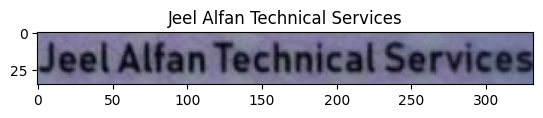

In [355]:
import os
import random

DATASET_PATH = "Datasets/ENGLISH/Synthetic_IDA_Custom_ALL_Rec_En_V1/test"

annotations = []
for file_path in glob.glob(os.path.join(DATASET_PATH, "**", "*.txt"), recursive=True):
    base_path, file_name = os.path.split(file_path)
    with open(file_path, "r") as reader:
        for line in reader.readlines():
            image_name, text = line.strip("\n").split(".jpg")
            image_name = image_name.strip() + ".jpg"
            text = text.strip()         
            annotations.append([base_path, image_name, text])
            
N = random.randint(0, len(annotations) - 1)
base_path, image_name, text = annotations[N]
ax = plt.subplot(1, 1, 1)
plt.imshow(Image.open(os.path.join(base_path, "images", image_name)).convert("RGB"))
ax.set_title(text)
plt.show()